In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t, norm
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler

np.random.seed(0)



In [14]:
n_samples = 500
n_features = 5 
n_simulations = 3000
std_noise_data = 10    


n_signal_features = 2  

beta_true_values = np.zeros(n_features)
beta_true_values[0] = 5  
beta_true_values[1] = -3 

X = np.random.normal(0, 1, size=(n_samples, n_features))
X = sm.add_constant(X, prepend=True) # Thêm cột intercept vào X


def create_data_with_signal_ols(X_input_with_intercept, true_betas_with_intercept, std_noise):
    """
    Tạo dữ liệu y cho OLS.
    X_input_with_intercept đã bao gồm cột hằng số.
    true_betas_with_intercept bao gồm giá trị cho intercept ở vị trí đầu tiên.
    """
    n = X_input_with_intercept.shape[0]


    linear_component = X_input_with_intercept @ true_betas_with_intercept
    noise = np.random.normal(0, std_noise, size = n)
    y = linear_component + noise
    return y

intercept_true = 2
beta_true_full = np.concatenate([[intercept_true], beta_true_values])


def fit_ols_model(X_data_with_intercept, y_data):
    """
    Sử dụng statsmodels.OLS để fit mô hình và lấy beta_hat, p_values.
    """
    model = sm.OLS(y_data, X_data_with_intercept)
    results = model.fit()
    beta_hat_ols = results.params      
    p_values_ols = results.pvalues    
    return beta_hat_ols, p_values_ols


beta_hat_list = []
p_values_list = []

for i in range(n_simulations):
    if i % 100 == 0:
        print(f"Running simulation {i+1}/{n_simulations}")

    current_y = create_data_with_signal_ols(X, beta_true_full, std_noise_data)
    
    beta_hat, p_values = fit_ols_model(X, current_y)
    
    beta_hat_list.append(beta_hat)
    p_values_list.append(p_values)



Running simulation 1/3000
Running simulation 101/3000
Running simulation 201/3000
Running simulation 301/3000
Running simulation 401/3000
Running simulation 501/3000
Running simulation 601/3000
Running simulation 701/3000
Running simulation 801/3000
Running simulation 901/3000
Running simulation 1001/3000
Running simulation 1101/3000
Running simulation 1201/3000
Running simulation 1301/3000
Running simulation 1401/3000
Running simulation 1501/3000
Running simulation 1601/3000
Running simulation 1701/3000
Running simulation 1801/3000
Running simulation 1901/3000
Running simulation 2001/3000
Running simulation 2101/3000
Running simulation 2201/3000
Running simulation 2301/3000
Running simulation 2401/3000
Running simulation 2501/3000
Running simulation 2601/3000
Running simulation 2701/3000
Running simulation 2801/3000
Running simulation 2901/3000



Trung bình các Beta_hat ước lượng:
Intercept    2.011434
Beta_X1      5.001137
Beta_X2     -2.992337
Beta_X3      0.007810
Beta_X4      0.008772
Beta_X5     -0.008790
dtype: float64

Beta_true (bao gồm intercept):
[ 2.  5. -3.  0.  0.  0.]


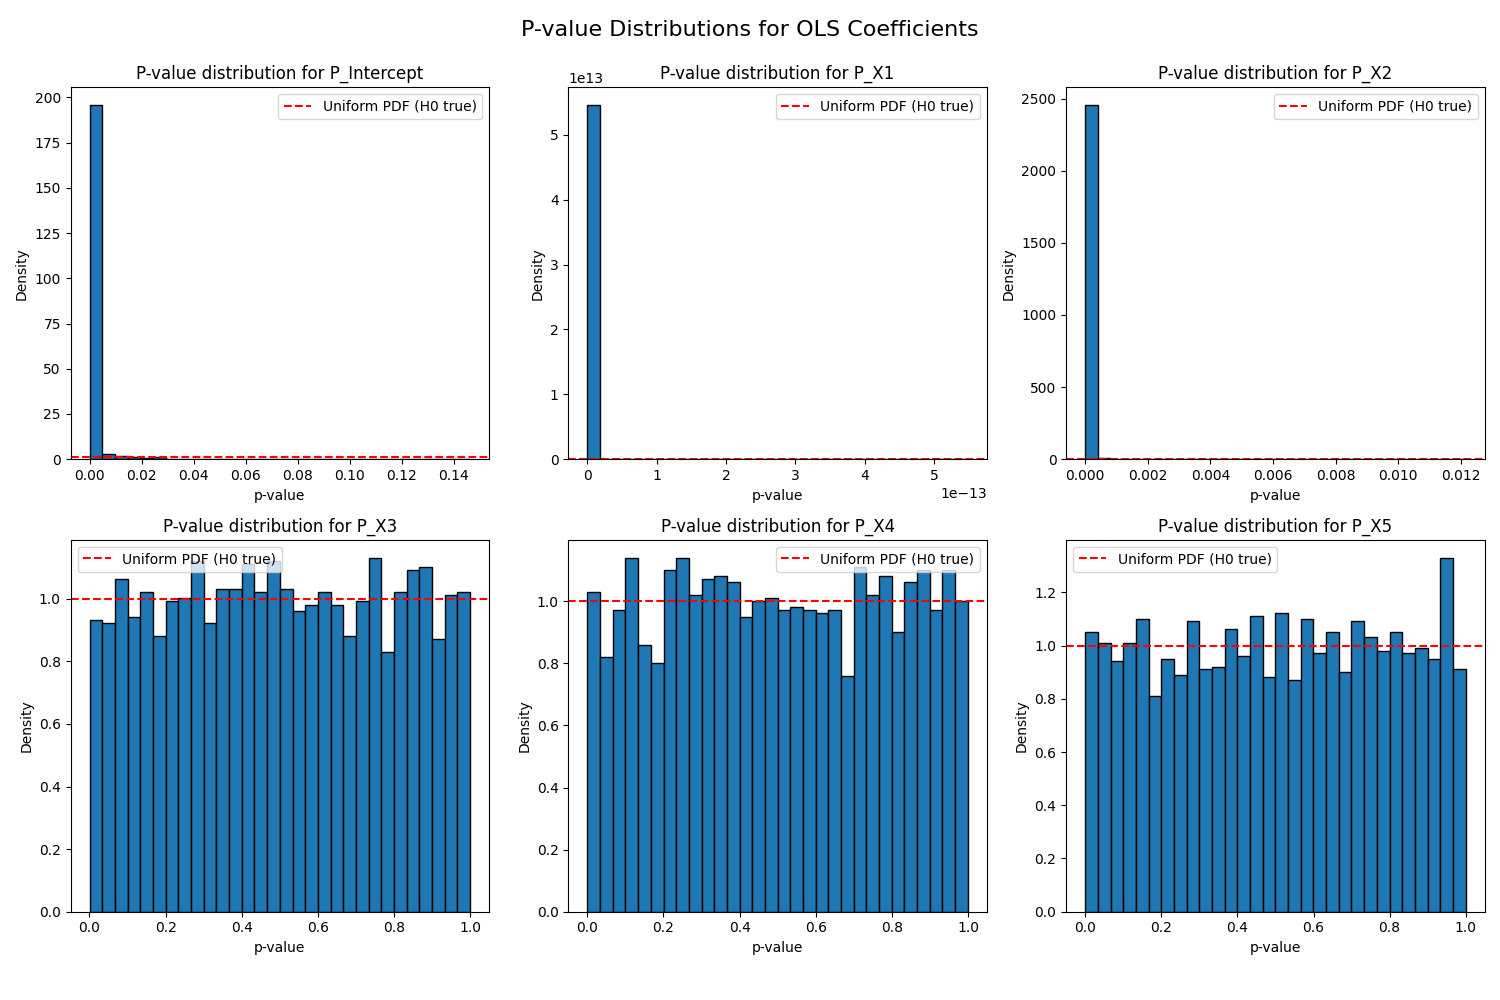

In [19]:

columns_beta = ['Intercept'] + [f'Beta_X{i+1}' for i in range(n_features)]
columns_pvalue = ['P_Intercept'] + [f'P_X{i+1}' for i in range(n_features)]

beta_hat_df = pd.DataFrame(beta_hat_list, columns=columns_beta)
pvalues_df = pd.DataFrame(p_values_list, columns=columns_pvalue)

print("\nTrung bình các Beta_hat ước lượng:")
print(beta_hat_df.mean())
print("\nBeta_true (bao gồm intercept):")
print(beta_true_full)


fig_p, axes_p = plt.subplots(2, 3, figsize=(15, 10)) 
axes_p = axes_p.flatten()


p_value_cols_to_plot = columns_pvalue 

for idx, col_name in enumerate(p_value_cols_to_plot):
    if idx < len(axes_p): 
        axes_p[idx].hist(pvalues_df[col_name], bins=30, edgecolor='black', density=True)
        axes_p[idx].axhline(1, color='red', linestyle='--', label='Uniform PDF (H0 true)')
        axes_p[idx].set_title(f'P-value distribution for {col_name}')
        axes_p[idx].set_xlabel('p-value')
        axes_p[idx].set_ylabel('Density')
        axes_p[idx].legend()


for i in range(len(p_value_cols_to_plot), len(axes_p)):
    fig_p.delaxes(axes_p[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
fig_p.suptitle("P-value Distributions for OLS Coefficients", fontsize=16)
plt.show()




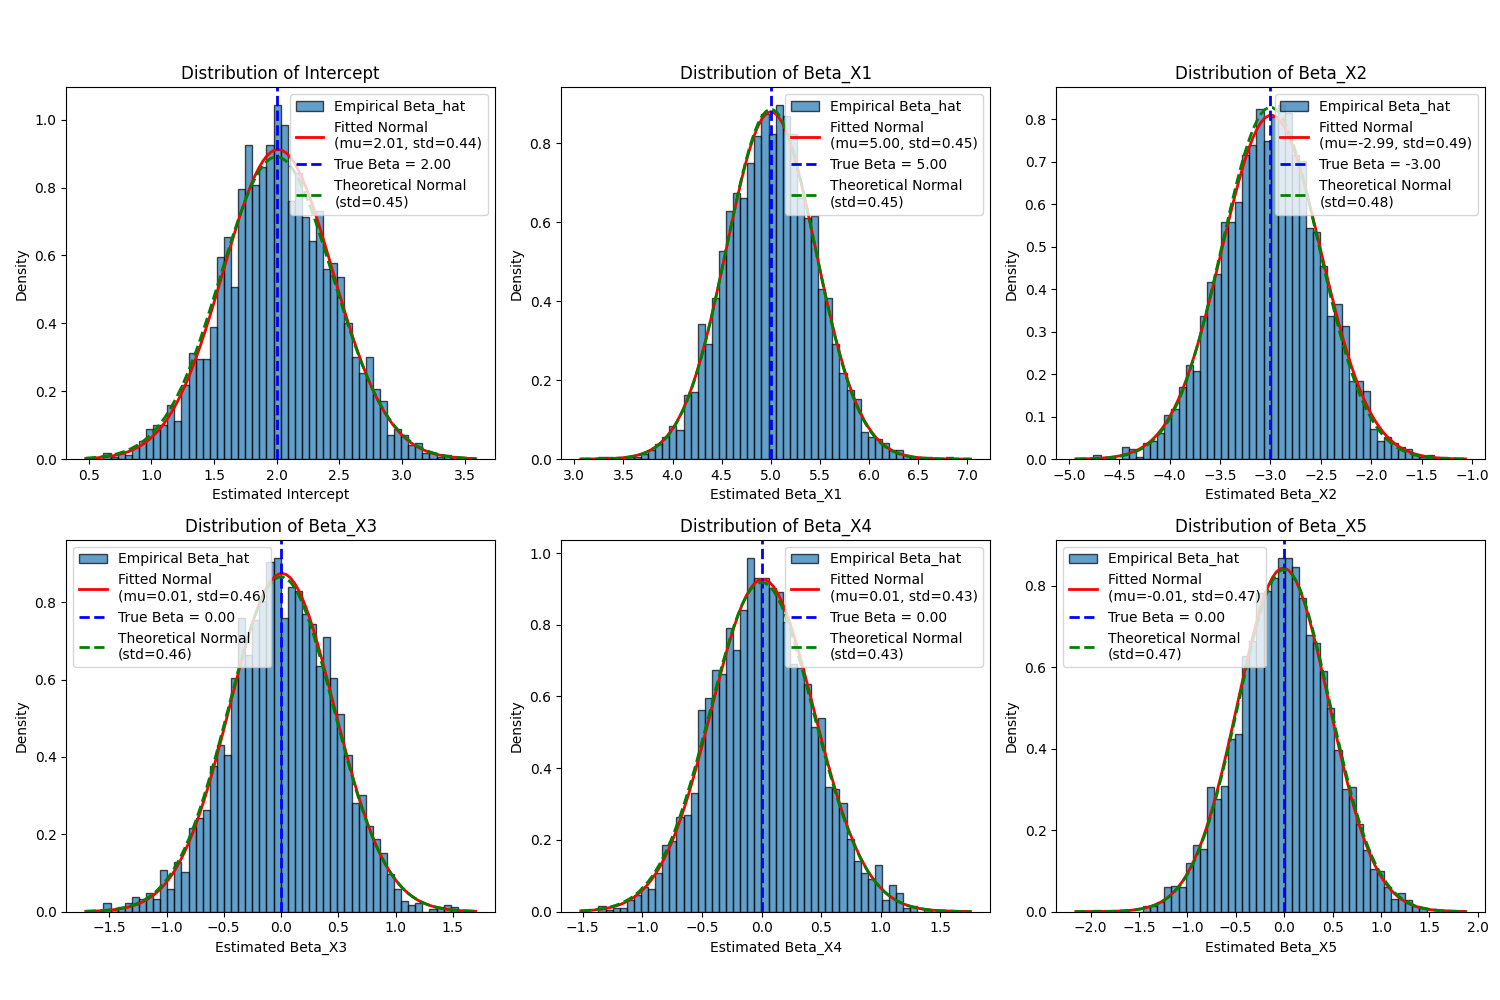

In [16]:
# --- Vẽ biểu đồ phân phối Beta_hat ---
fig_b, axes_b = plt.subplots(2, 3, figsize=(15, 10)) # Điều chỉnh kích thước
axes_b = axes_b.flatten()

sigma_squared_true_noise = std_noise_data ** 2
var_beta_hat_theoretical = sigma_squared_true_noise * np.linalg.inv(X.T @ X)
std_each_beta_hat_theoretical = np.sqrt(np.diag(var_beta_hat_theoretical))


for idx, col_name in enumerate(columns_beta):
    if idx < len(axes_b):
        beta_values_for_hist = beta_hat_df[col_name]
        axes_b[idx].hist(beta_values_for_hist, bins=50, density=True, edgecolor='black', alpha=0.7, label='Empirical Beta_hat')
        
        # Fit phân phối Normal vào dữ liệu thực nghiệm
        mu_emp, std_emp = norm.fit(beta_values_for_hist)
        xmin, xmax = axes_b[idx].get_xlim()
        x_norm_emp = np.linspace(xmin, xmax, 100)
        p_norm_emp = norm.pdf(x_norm_emp, mu_emp, std_emp)
        axes_b[idx].plot(x_norm_emp, p_norm_emp, 'r-', linewidth=2, label=f'Fitted Normal\n(mu={mu_emp:.2f}, std={std_emp:.2f})')

        # Vẽ đường thẳng cho beta_true
        true_val = beta_true_full[idx]
        axes_b[idx].axvline(true_val, color='blue', linestyle='--', linewidth=2, label=f'True Beta = {true_val:.2f}')
        
        
        std_theoretical_val = std_each_beta_hat_theoretical[idx]
        p_norm_theory = norm.pdf(x_norm_emp, true_val, std_theoretical_val)
        axes_b[idx].plot(x_norm_emp, p_norm_theory, 'g--', linewidth=2, label=f'Theoretical Normal\n(std={std_theoretical_val:.2f})')

        axes_b[idx].set_title(f'Distribution of {col_name}')
        axes_b[idx].set_xlabel(f'Estimated {col_name}')
        axes_b[idx].set_ylabel('Density')
        axes_b[idx].legend()

for i in range(len(columns_beta), len(axes_b)):
    fig_b.delaxes(axes_b[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()